Goal: create maps of street networks, but only within a buffer around a geocoded place.

Next goal: functions to measure and visualize urban indicators.

Steps:
- write code to plot heatmap of point density [DONE]
- convert heatmap code to function [DONE]
- write code to clip heatmap to buffer ring [DONE]
- write code to get osm amenity data based on category

Ideas for Urban Indicators:
- intersection density (hexbin/heatmap) [DONE]
- density of x-height buildings (hexbin/heatmap)
- density of x kind of amenity (hexbin/heatmap)
    - sustenance (restaurants, bars, etc.)
    - education (school, college, university, etc.)
    - healthcare (clinic, hospital, etc.)
    - public service (fire station, town hall, police, etc.)
- density of shops [DONE]
- isochrone from geocoded point
- betweenness centrality of street intersections [DONE]

Step 1: Import packages

In [157]:
import osmnx as ox
import geopandas as gpd
import contextily as cx
import shapely as shp
import matplotlib.pyplot as plt
import numpy as np
from scipy import ndimage
import networkx as nx

Step 2: Generate buffer around location of interest

In [158]:
# Set name for Nominatim query
query = "Marikina"
buffer_dist = 1_500

# Get buffer with aforementioned parameters using custom function
from urban_indicators_scripts import get_buffer_from_place

buffer = get_buffer_from_place(query, buffer_dist)

c:\Users\HOWARD\miniconda3\envs\ccims\Lib\site-packages\pyproj\transformer.py:820: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return self._transformer._transform_point(


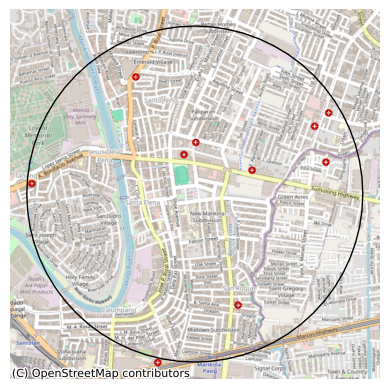

In [159]:
# Check if buffer location is correct
ax = buffer.to_crs("EPSG:3857").plot(
    facecolor="none"
)
cx.add_basemap(ax=ax, source=cx.providers.OpenStreetMap.Mapnik)
ax.set_axis_off()

Step 3: Extract street network within buffer then pre-process

In [160]:
# Get road network within buffer
graph = ox.graph_from_polygon(
    buffer.geometry[0],
    network_type="all_private",
    retain_all=True,
    simplify=True
)

# Convert intersections and streets to geodataframe
intersections, streets = ox.graph_to_gdfs(graph)

In [161]:
# Reproject both GDFs to pseudo-mercator
streets = streets.to_crs("EPSG:3857")
intersections = intersections.to_crs("EPSG:3857")

In [162]:
# Parse `lanes` column in streets GDF using custom function
from urban_indicators_scripts import parse_street_lanes

streets = parse_street_lanes(streets)
streets.lanes.unique()

array([2, 1, 4, 6, 5, 3])

In [163]:
streets.head()

osmid  lanes                      name  \
u        v          key                                                
21322195 8489619532 0     357121634      2           Guerilla Street   
         8489619520 0    1178024567      2           Guerilla Street   
21322197 32284894   0       4357068      2    Eraño G. Manalo Street   
         33118939   0       4989944      2  F. Alfelor Senior Street   
         26546377   0     261332447      2           Aquilina Street   

                          highway maxspeed  oneway reversed   length  \
u        v          key                                                
21322195 8489619532 0    tertiary       40   False    False    6.322   
         8489619520 0    tertiary      NaN   False     True    5.717   
21322197 32284894   0    tertiary       40    True    False  264.153   
         33118939   0    tertiary      NaN   False     True   53.423   
         26546377   0    tertiary      NaN   False     True   86.098   

                                                                  geometry  \
u        v          key                                                      
21322195 8489619532 0    LINESTRING (13480558.757 1647485.444, 13480552...   
         8489619520 0    LINESTRING (13480558.757 1647485.444, 13480564...   
21322197 32284894   0    LINESTRING (13480761.292 1648028.435, 13480647...   
         33118939   0    LINESTRING (13480761.292 1648028.435, 13480711...   
         26546377   0    LINESTRING (13480761.292 1648028.435, 13480841...   

                        width bridge access  ref service tunnel  
u        v          key                                          
21322195 8489619532 0     NaN    NaN    NaN  NaN     NaN    NaN  
         8489619520 0     NaN    NaN    NaN  NaN     NaN    NaN  
21322197 32284894   0     NaN    NaN    NaN  NaN     NaN    NaN  
         33118939   0     NaN    NaN    NaN  NaN     NaN    NaN  
         26546377   0     NaN    NaN    NaN  NaN     NaN    NaN

Step 4: Plotting the street network and intersection heatmap

d:\AUTOGIS\final-assignment-jeromemaiquez\urban_indicators_scripts.py:384: RuntimeWarning: divide by zero encountered in log2
  logheatmap = np.log2(heatmap)
d:\AUTOGIS\final-assignment-jeromemaiquez\urban_indicators_scripts.py:388: DeprecationWarning: Please use `gaussian_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  logheatmap = ndimage.filters.gaussian_filter(


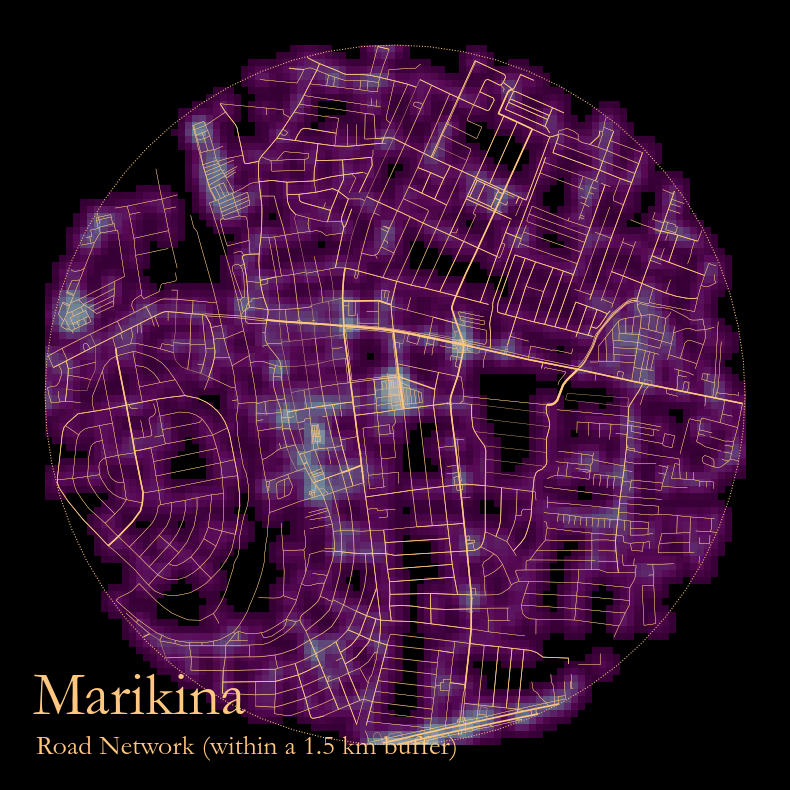

In [164]:
# Plot street network
from urban_indicators_scripts import plot_streets, plot_heatmap

fig, ax, ring_bounds = plot_streets(
    streets,
    buffer,
    color_scheme="copper"
)

plot_heatmap(
    intersections,
    "street_count",
    ax=ax,
    alpha=0.7,
    color_scheme="BuPu_r",
    bounds=ring_bounds
)

Part B: Generating a heatmap for other POIs

Step 1: Extract shops within buffer

In [165]:
# Extract all shops within the buffer
shop_pois = ox.features_from_polygon(
    buffer.geometry[0],
    {
        "shop": True,
        # "amenity": ["fast_food", "restaurant", "cafe"]
    }
)

# Examine number of rows and columns
shop_pois.shape

(465, 85)

Step 2: Clean up shop data

In [166]:
# Import drop_nan_cols function we created
from urban_indicators_scripts import drop_nan_cols, filter_elem_type

# Apply imported function
# Parameters: gdf, max % of rows that are NaNs
shop_pois = drop_nan_cols(shop_pois, 0.75)

In [167]:
# Examine # of rows & cols after pre-processing
shop_pois.shape

(465, 5)

In [168]:
# Flatten column indices
# (this should be in the function)
shop_pois = shop_pois.reset_index()

shop_pois.head()

,element_type,osmid,name,shop,geometry,addr:city,addr:street
0,node,243088270,Robinsons Supermarket,supermarket,POINT (121.10230 14.63525),NaN,NaN
1,node,268443427,Great Bikes,bicycle,POINT (121.09269 14.62326),Marikina,J. P. Rizal
2,node,268443428,Jorge Bike Shop,bicycle,POINT (121.09515 14.62345),Marikina,J. P. Rizal
3,node,268443431,John Wilkie,bicycle,POINT (121.09672 14.62919),Marikina,J. P. Rizal
4,node,322797574,Royal Star,appliance,POINT (121.09718 14.63591),Marikina,NaN


In [169]:
# Assign weight to all shops (for heatmap)
shop_pois["weight"] = 1.0

In [170]:
# Reproject to Pseudo-Mercator
shop_pois = shop_pois.to_crs("EPSG:3857")

In [171]:
# Set feature geometries as their centroids
# (this should be in the function)
shop_pois["geometry"] = shop_pois["geometry"].centroid
shop_pois.shape

(465, 8)

Step 3: Plot shop density heatmap

d:\AUTOGIS\final-assignment-jeromemaiquez\urban_indicators_scripts.py:384: RuntimeWarning: divide by zero encountered in log2
  logheatmap = np.log2(heatmap)
d:\AUTOGIS\final-assignment-jeromemaiquez\urban_indicators_scripts.py:388: DeprecationWarning: Please use `gaussian_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  logheatmap = ndimage.filters.gaussian_filter(


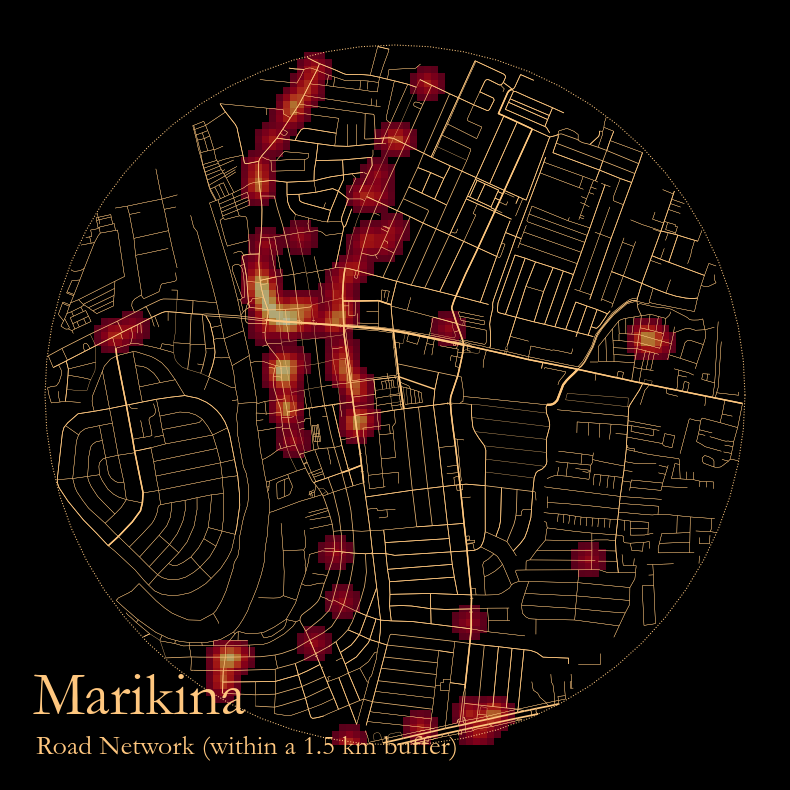

In [172]:
fig, ax, ring_bounds = plot_streets(
    streets,
    buffer,
    color_scheme="copper"
)

plot_heatmap(
    shop_pois,
    "weight",
    bins=100,
    ax=ax,
    alpha=0.7,
    color_scheme="YlOrRd_r",
    bounds=ring_bounds
)

Part C: Visualizing betweenness centrality of street intersections

Step 1: Calculate betweenness centrality per node

In [173]:
bc = nx.betweenness_centrality(graph, weight="street_count")

Step 2: Join betweenness values to each node via osmid

In [174]:
nx.set_node_attributes(graph, bc, "bc")

Step 3: Convert graph to GDFS, then preprocess

In [175]:
intersections, streets = ox.graph_to_gdfs(graph)

In [176]:
streets = streets.to_crs("EPSG:3857")
intersections = intersections.to_crs("EPSG:3857")

In [177]:
# Parse `lanes` column in streets GDF using custom function
from urban_indicators_scripts import parse_street_lanes

streets = parse_street_lanes(streets)
streets.lanes.unique()

array([2, 1, 4, 6, 5, 3])

In [178]:
# Multiply by 1,000 (since function calculates log of heatmap)
intersections["bc_1k"] = intersections["bc"] * 1_000

Step 4: Plot betweenness centrality!

d:\AUTOGIS\final-assignment-jeromemaiquez\urban_indicators_scripts.py:384: RuntimeWarning: divide by zero encountered in log2
  logheatmap = np.log2(heatmap)
d:\AUTOGIS\final-assignment-jeromemaiquez\urban_indicators_scripts.py:388: DeprecationWarning: Please use `gaussian_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  logheatmap = ndimage.filters.gaussian_filter(


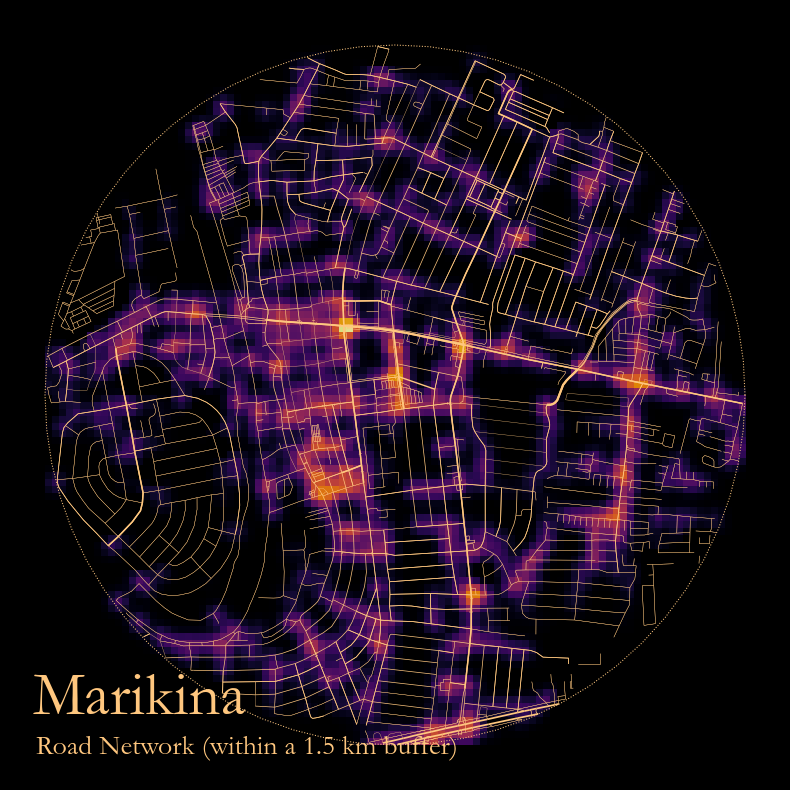

In [179]:
# Plot street network
from urban_indicators_scripts import plot_streets, plot_heatmap

fig, ax, ring_bounds = plot_streets(
    streets,
    buffer,
    color_scheme="copper"
)

# Plot heatmap of betweenness centrality
plot_heatmap(
    intersections,
    "bc_1k",
    ax=ax,
    alpha=0.9,
    color_scheme="inferno",
    bounds=ring_bounds
)